In [1]:
import os

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torchvision import transforms, datasets
from sklearn.utils.class_weight import compute_class_weight

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Feature extraction and head creation

#### Load model

In [3]:
MODEL_PATH = "../../speciesnet/models/speciesnet-pytorch-v4.0.1a-v1/always_crop_99710272_22x8_v12_epoch_00148.pt"
NUM_CLASSES = 26  # Number of target Polish species

In [4]:
model = torch.load(MODEL_PATH, map_location="cuda", weights_only=False)
# print(model)
# model.print_readable()

for p in model.parameters():
    p.requires_grad = False

model.eval()

GraphModule(
  (initializers): Module()
  (SpeciesNet/efficientnetv2-m/rescaling/mul): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/rescaling/add): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/stem_conv/Conv2D__6): OnnxTranspose()
  (SpeciesNet/efficientnetv2-m/stem_conv/Conv2D): Sequential(
    (0): OnnxPadStatic()
    (1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2))
  )
  (SpeciesNet/efficientnetv2-m/stem_activation/Sigmoid): Sigmoid()
  (SpeciesNet/efficientnetv2-m/stem_activation/mul_1): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/block1a_project_conv/Conv2D): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (SpeciesNet/efficientnetv2-m/block1a_project_activation/Sigmoid): Sigmoid()
  (SpeciesNet/efficientnetv2-m/block1a_project_activation/mul_1): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/block1a_add/add): OnnxBinaryMathOperation()
  (SpeciesNet/efficientnetv2-m/block1b_project_conv/Conv2D): Conv2d(24, 24, 

#### Get number of speciesnet outputs

In [5]:
dummy = torch.randn(1, 480, 480, 3).to('cuda')
out = model(dummy)
n_original_classes = out.shape[1]
print(out.shape)

torch.Size([1, 2498])


In [6]:
scale = model.initializers.onnx_initializer_0.cpu().numpy()
offset = model.initializers.onnx_initializer_1.cpu().numpy()

print("scale:", scale)
print("offset:", offset)

scale: 1.9921875
offset: -1.0


#### Extract features

In [7]:
model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, input_1):
        # No stacktrace found for following nodes
        initializers_onnx_initializer_0 = self.initializers.onnx_initializer_0
        species_net_efficientnetv2_m_rescaling_mul = getattr(self, "SpeciesNet/efficientnetv2-m/rescaling/mul")(input_1, initializers_onnx_initializer_0);  input_1 = initializers_onnx_initializer_0 = None
        initializers_onnx_initializer_1 = self.initializers.onnx_initializer_1
        species_net_efficientnetv2_m_rescaling_add = getattr(self, "SpeciesNet/efficientnetv2-m/rescaling/add")(species_net_efficientnetv2_m_rescaling_mul, initializers_onnx_initializer_1);  species_net_efficientnetv2_m_rescaling_mul = initializers_onnx_initializer_1 = None
        species_net_efficientnetv2_m_stem_conv_conv2d__6 = getattr(self, "SpeciesNet/efficientnetv2-m/stem_conv/Conv2D__6")(species_net_efficientnetv2_m_rescaling_add);  species_net_efficientnetv2_m_rescaling_add = None
        species_net_effi

'class GraphModule(torch.nn.Module):\n    def forward(self, input_1):\n        # No stacktrace found for following nodes\n        initializers_onnx_initializer_0 = self.initializers.onnx_initializer_0\n        species_net_efficientnetv2_m_rescaling_mul = getattr(self, "SpeciesNet/efficientnetv2-m/rescaling/mul")(input_1, initializers_onnx_initializer_0);  input_1 = initializers_onnx_initializer_0 = None\n        initializers_onnx_initializer_1 = self.initializers.onnx_initializer_1\n        species_net_efficientnetv2_m_rescaling_add = getattr(self, "SpeciesNet/efficientnetv2-m/rescaling/add")(species_net_efficientnetv2_m_rescaling_mul, initializers_onnx_initializer_1);  species_net_efficientnetv2_m_rescaling_mul = initializers_onnx_initializer_1 = None\n        species_net_efficientnetv2_m_stem_conv_conv2d__6 = getattr(self, "SpeciesNet/efficientnetv2-m/stem_conv/Conv2D__6")(species_net_efficientnetv2_m_rescaling_add);  species_net_efficientnetv2_m_rescaling_add = None\n        species

In [8]:
class SpeciesNetFeatures(nn.Module):
    def __init__(self, graph_module, feature_node_name):
        super().__init__()
        self.graph = graph_module
        self.feature_node_name = feature_node_name
        self._features = None
        
        # register hook on the ONNX-traced layer
        layer = getattr(self.graph, feature_node_name)
        layer.register_forward_hook(self._hook)

    def _hook(self, module, inp, out):
        self._features = out

    def forward(self, x):
        _ = self.graph(x)              # run through full graph
        return self._features          # return features BEFORE final classifier

In [9]:
FEATURE_NODE = "SpeciesNet/efficientnetv2-m/avg_pool/Mean_Squeeze__3825"
feat_extractor = SpeciesNetFeatures(model, FEATURE_NODE).to("cuda")

In [10]:
feat_extractor

SpeciesNetFeatures(
  (graph): GraphModule(
    (initializers): Module()
    (SpeciesNet/efficientnetv2-m/rescaling/mul): OnnxBinaryMathOperation()
    (SpeciesNet/efficientnetv2-m/rescaling/add): OnnxBinaryMathOperation()
    (SpeciesNet/efficientnetv2-m/stem_conv/Conv2D__6): OnnxTranspose()
    (SpeciesNet/efficientnetv2-m/stem_conv/Conv2D): Sequential(
      (0): OnnxPadStatic()
      (1): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2))
    )
    (SpeciesNet/efficientnetv2-m/stem_activation/Sigmoid): Sigmoid()
    (SpeciesNet/efficientnetv2-m/stem_activation/mul_1): OnnxBinaryMathOperation()
    (SpeciesNet/efficientnetv2-m/block1a_project_conv/Conv2D): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (SpeciesNet/efficientnetv2-m/block1a_project_activation/Sigmoid): Sigmoid()
    (SpeciesNet/efficientnetv2-m/block1a_project_activation/mul_1): OnnxBinaryMathOperation()
    (SpeciesNet/efficientnetv2-m/block1a_add/add): OnnxBinaryMathOperation()
    (SpeciesNet/e

#### Check number of features output by model, before classifier

In [11]:
dummy = torch.randn(1, 480, 480, 3).to("cuda")
feat = feat_extractor(dummy)
feature_dim = feat.shape[1]
print("Feature dim:", feature_dim)

Feature dim: 1280


#### Change classifier in new model

In [12]:
class NewClassifier(nn.Module):
    def __init__(self, feature_dim: int, num_classes: int, dropout: float=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.net(x)

class SpeciesnetPolish(nn.Module):
    def __init__(self, feature_extractor: SpeciesNetFeatures, num_classes: int):
        super().__init__()
        self.feature_extractor = feature_extractor

        # freeze original SpeciesNet
        for p in self.feature_extractor.parameters():
            p.requires_grad = False

        # get feature dim
        dummy = torch.randn(1, 480, 480, 3).to("cuda")
        feat = self.feature_extractor(dummy)
        feature_dim = feat.shape[1]

        self.classifier = NewClassifier(feature_dim, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        f = self.feature_extractor(x)
        out = self.classifier(f)
        return out

## Training

##### Dataloader

In [22]:
IMG_SIZE = 480
BATCH_SIZE = 24
VALID_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

In [23]:
# Filter: accept only files inside pictures_cropped
def is_valid_image(path):
    dirname = os.path.basename(os.path.dirname(path))
    return dirname == "pictures_cropped" and path.lower().endswith(VALID_EXT)

dataset = datasets.ImageFolder(
    root="../../data",
    transform=transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor()
    ]),
    is_valid_file=is_valid_image,
)
print('Number of classes: ', len(dataset.classes))
print('Number of images: ', len(dataset))

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

Number of classes:  26
Number of images:  22810


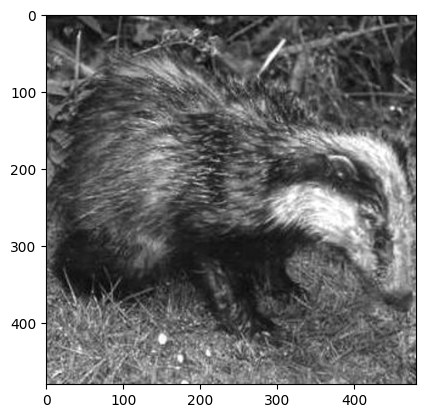

In [24]:
import matplotlib.pyplot as plt

plt.imshow(dataset[100][0].numpy()[0], cmap='gray')

:( I don't think anything better can be done here

In [25]:
img = dataset[0][0].numpy()
internal = img * scale + offset
print(internal.min(), internal.max())

-0.8984375 0.9921875


In [26]:
img.shape

(3, 480, 480)

##### The loop

In [27]:
number_of_epochs = 9

imbalanced dataset:

In [28]:
y_train = [row[1] for row in dataset.samples]
len(y_train)

classes = dataset.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

In [40]:
polish_model = SpeciesnetPolish(feat_extractor, NUM_CLASSES).to("cuda")

In [41]:
optimizer = torch.optim.Adam(polish_model.classifier.parameters(), lr=1e-3)
caler = GradScaler('cuda')
criterion = nn.CrossEntropyLoss(weight=weights)
scaler = GradScaler()

polish_model.train()
current_batch = 1

for epoch in range(number_of_epochs):
    print('epoch ', epoch)
    epoch_loss = 0
    current_batch = 0
    
    for images, labels in dataloader:
        if current_batch % 400 == 0:
            print(current_batch)
        images, labels = images.cuda(), labels.cuda()
        
        with autocast('cuda'):
            logits = polish_model(images)
            loss = criterion(logits, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        current_batch += 1
    print('loss:', epoch_loss)

checkpoint = {
    'state_dict': polish_model.state_dict(),
    'class_names': classes,
    'feature_node': FEATURE_NODE,
    'num_classes': NUM_CLASSES
}
torch.save(checkpoint, "speciesnet_polish_checkpoint.pt")

epoch  0
400
800
loss: 413.5042191874236
epoch  1
1200
1600
loss: 256.01703556533903
epoch  2
2000
2400
2800
loss: 220.40497888065875
epoch  3
3200
3600
loss: 189.50170791853452
epoch  4
4000
4400
loss: 170.80888654576847
epoch  5
4800
5200
5600
loss: 146.67521658027545
epoch  6
6000
6400
loss: 132.96926088325563
epoch  7
6800
7200
7600
loss: 121.70972891474958
epoch  8
8000
8400
loss: 116.54944818792865
